In [2]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.metrics import confusion_matrix
import csv
import warnings

# Python uyarılarını kapatma
warnings.filterwarnings('ignore')


2024-05-29 17:33:44.729051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 17:33:44.729179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 17:33:44.840882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# CSV DOSYASI OLUŞTURMA

In [3]:
# Dosyanın var olup olmadığını kontrol edin ve varsa silin
data_csv='/kaggle/working/dataset.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"{data_csv} dosyası silindi.")
else:
    print(f"{data_csv} dosyası bulunamadı.")

data_csv='/kaggle/working/dataset.csv'
data1_dir = '/kaggle/input/fake-vs-real-face-classification/train'
data2_dir = '/kaggle/input/fake-vs-real-face-classification/Validation'

data3_dir = '/kaggle/input/hardfakevsrealfaces'

# CSV dosyasının varlığını kontrol et

if os.path.exists(data_csv):
    print('exists')
else:
    data_dirs = [data3_dir]

    # Define the path for the CSV file
    csv_file = 'dataset.csv'
    data_csv = csv_file

    # Define the class mapping
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])
                        
    print(f"{csv_file} dosyası oluşturuldu.")

/kaggle/working/dataset.csv dosyası bulunamadı.
dataset.csv dosyası oluşturuldu.


# Resim yükleme işlemleri 

In [4]:
import pandas as pd


data = pd.read_csv(data_csv)

height, width = 224, 224

def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))


X = np.empty((data.shape[0], height, width, 3), dtype=np.uint8)  # Veri tipini float32 olarak ayarladık
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Dosya yolunu al
    img = load_img(img_path, target_size=(height, width))  # Resmi yükle ve boyutlandır
    img_array = np.array(img)  # Resmi numpy array'e çevir ve normalize et
    X[i] = img_array  # Array'i X'e ekle

print(X.shape)

(1289, 224, 224, 3)


# Veri Seti Içeriği

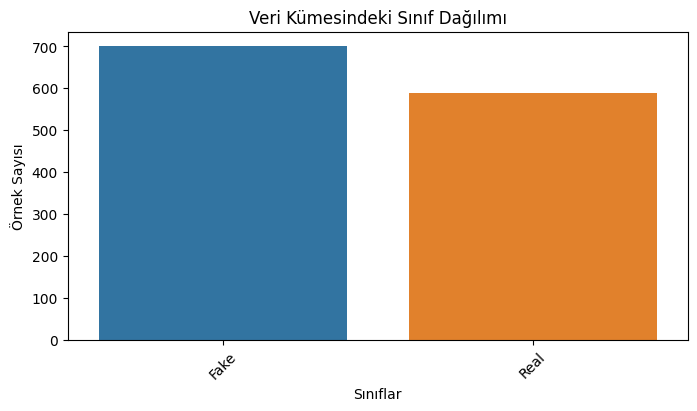

In [50]:
# Veri setindeki sınıf dağılımını görselleştirme
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.title('Veri Kümesindeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()


# Veri seti bölme

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(902, 224, 224, 3)
(193, 224, 224, 3)
(194, 224, 224, 3)


# MobileNetV3Large Model Oluşturma

In [6]:
tf.keras.backend.clear_session()

# MobilNetV3 Large modelini yükleme
mobilenetv3 = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: MobilNetV3 Large modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(mobilenetv3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model_mobilenetv3 = Model(mobilenetv3.input, output)

# Modeli derleme
model_mobilenetv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Modelin Eğitimi

In [7]:
# Modelin eğitimi
epochs=15
history = model_mobilenetv3.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))

Epoch 1/15
 1/29 ━━━━━━━━━━━━━━━━━━━━ 31:27 67s/step - accuracy: 0.5312 - loss: 2.2822

I0000 00:00:1717004111.827037      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717004111.910766      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8537 - loss: 2.8770  

W0000 00:00:1717004147.336657      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717004151.615824      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8566 - loss: 2.8311 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9963 - loss: 0.0424 - val_accuracy: 0.9896 - val_loss: 0.1539
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 1.0000 - loss: 5.5035e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9991 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9996 - loss: 0.0132 - val_accuracy: 0.9896 - val_loss: 0.3120
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9956 - loss: 0.0482 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9977 - loss: 0.0228 - val_accurac

# Modelin Grafikleri ve sonuçları

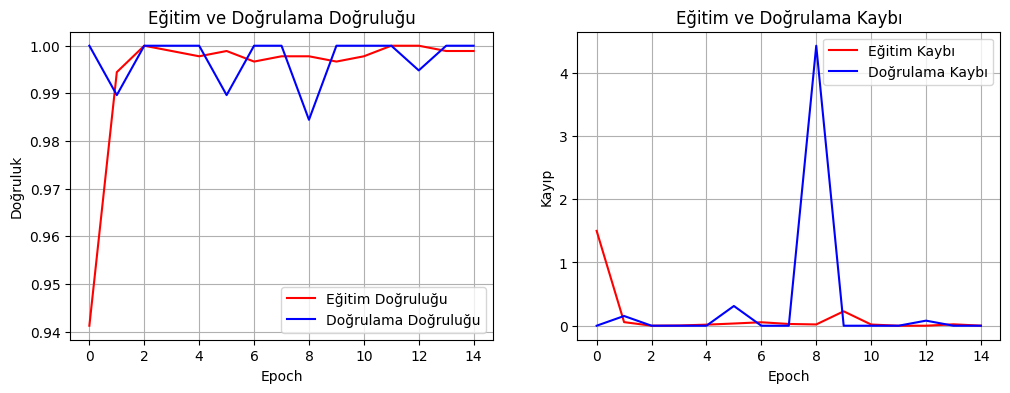

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


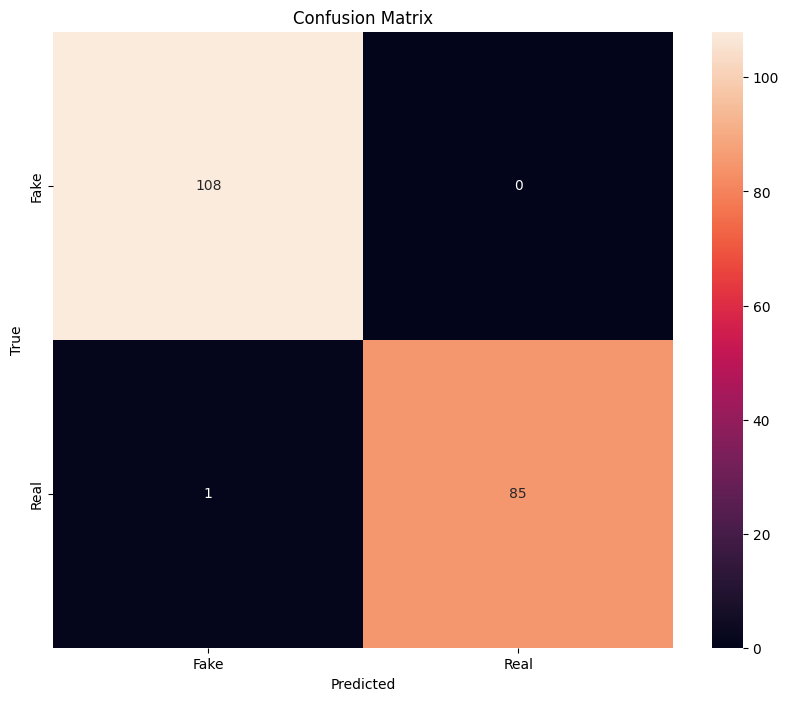

Precision: 0.9949
Recall: 0.9948
F1 Score: 0.9948
Test Accuracy: 0.9948


In [27]:
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model_mobilenetv3.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g',  xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))


# MobileNetV3Large ile Veri Artırma
#### Burada ImageDataGenerator kullanarak veri artırımı yapıyoruz. Bu işlemi, veri setini artırmanın modelin performansı üzerindeki etkisini öğrenmek amacıyla gerçekleştiriyoruz.

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True
)

In [46]:
tf.keras.backend.clear_session()

# MobilNetV3 Large modelini yükleme
mobilenetv3 = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: MobilNetV3 Large modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(mobilenetv3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model_mobilenetv3Aug = Model(mobilenetv3.input, output)

# Modeli derleme
model_mobilenetv3Aug.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [47]:
# Modelin eğitimi
from tensorflow.keras.callbacks import EarlyStopping
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
epochs = 15
# EarlyStopping callback
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=6,restore_best_weights=True  )
# Modelin eğitimi
history = model_mobilenetv3Aug.fit(
    train_datagen, 
    epochs=epochs, 
    validation_data=(X_val, y_val),
    callbacks=early_stopping_monitor
)

Epoch 1/15
 1/29 ━━━━━━━━━━━━━━━━━━━━ 23:03 49s/step - accuracy: 0.4375 - loss: 2.9252

W0000 00:00:1717005690.276150      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.8598 - loss: 1.9006

W0000 00:00:1717005717.777040      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717005721.426918      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8623 - loss: 1.8819 - val_accuracy: 0.9896 - val_loss: 0.4051
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.9970 - loss: 0.0724 - val_accuracy: 0.9896 - val_loss: 0.2763
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.9926 - loss: 0.1718 - val_accuracy: 0.9948 - val_loss: 0.0538
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9912 - loss: 0.2904 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 1.0000 - loss: 1.6286e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 1.0000 - loss: 3.5903e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 1.0000 - loss: 6.3897e-08 - v

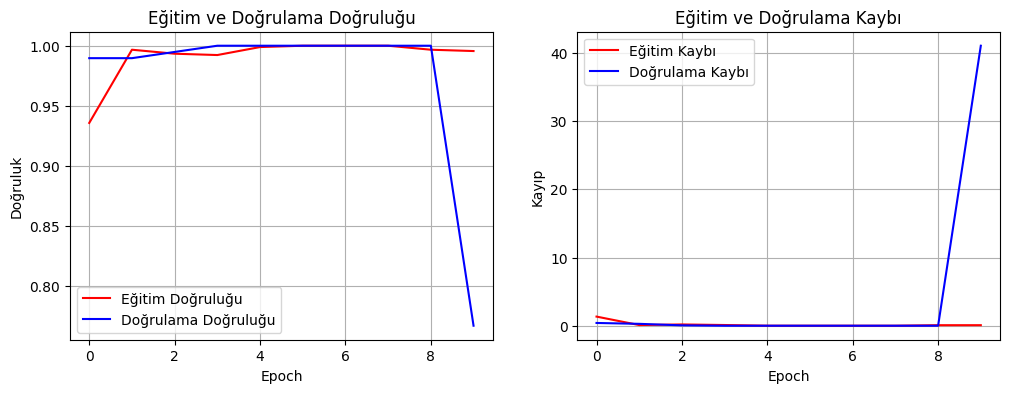

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

W0000 00:00:1717005821.809800      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 592ms/step


W0000 00:00:1717005825.359875      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


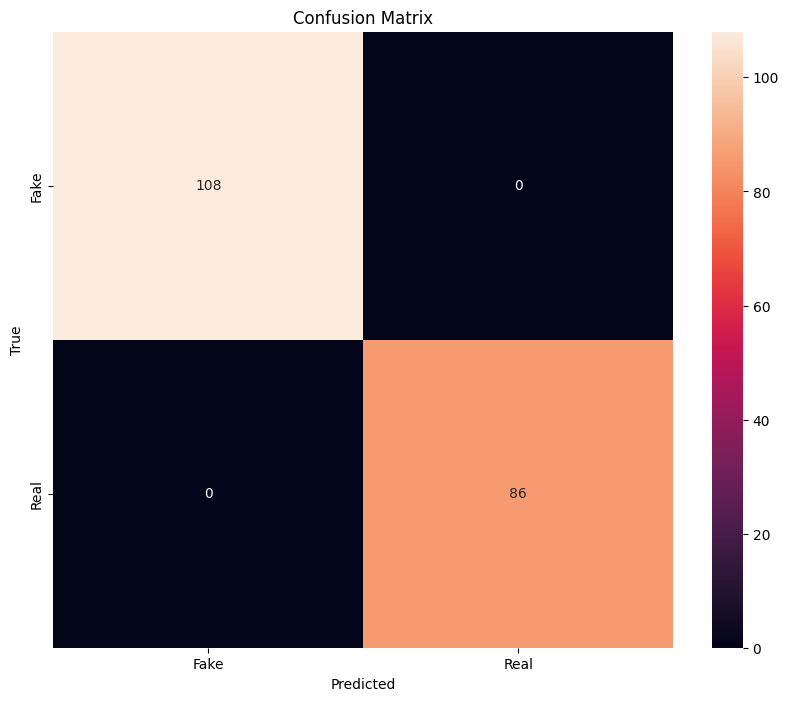

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Test Accuracy: 1.0000


In [48]:
from sklearn.metrics import confusion_matrix

# Doğruluk ve kayıp grafiği
# Eğitim ve doğrulama doğruluğu ve kaybı grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model_mobilenetv3Aug.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))


### Veri artırma ile hızlı bir başlangıç yaptık ve early stopping callback'i ile erkenden durarak 8 epoch sonunda %100 doğruluk elde ettik.